In [1]:
import os
from typing import  List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
import sqlite3
from langchain.tools import Tool
from langchain_core.tools import tool

connection = sqlite3.connect("gym.db")

In [2]:
os.environ["GROQ_API_KEY"] = "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"
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [3]:

@tool
def serach_by_sub_muscle_tool(TargetedSubMuscles: str, MainMuscle: str):
    """
    Fetches exercises from the SQLite database based on targeted and main muscles.
  Args:
        inputs (str): 'TargetedMuscles' and 'MainMuscle'.
        
    Returns:
    List: A list of query results."""
    print("i am here")
    print("main muscle", MainMuscle)
    cursor = connection.cursor()
    query = """
        SELECT * 
        FROM exercises
        WHERE sub_muscles LIKE ?
        OR main_muscle LIKE ?;
    """
    # Use '%' wildcard for LIKE
    parameters = (f"%{TargetedSubMuscles}%", f"%{MainMuscle}%")
    cursor.execute(query, parameters)
    rows = cursor.fetchall()
    
    exercises = []
    for row in rows:
        exercises.append(row)
    
    return exercises

    

In [4]:
tools=[serach_by_sub_muscle_tool]

In [5]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000216FE21A3C0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000216FE26C050>, model_name='llama-3.3-70b-versatile', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [6]:
def search_exercises_sqlite(main: str = None, sub: str = None):
    cursor = connection.cursor()
    cursor.execute(
        """
        SELECT * 
        FROM exercises
        WHERE sub_muscles LIKE ?
        OR main_muscle LIKE ?;
        """,
        (f"%{sub}%", f"%{main}%")
    )
    rows = cursor.fetchall()
    print("I am here")
    # Display the results
    return rows


In [7]:
class MainMuscle(TypedDict):
    main_muscle: str=Field(description="main muscle name")
    sub_muscle: List[str]=Field(description="list of sub_muscle groups")
    level_of_cardio: str=Field(description="level of cardio")
    @property
    def summary(self):
        return f"name: {self.main_muscle}, description: {self.description}, level_of_cardio: {self.level_of_cardio}"

In [8]:
class Perspectives(BaseModel):
    muscle_workouts: List[MainMuscle] = Field(
        description="Comprehensive list of all main muscles and their sub_muscles.",
    )

In [9]:
class SubMuscleExercises(TypedDict):
    sub_muscle: str = Field(description="sub_muscle name")
    exercise: str = Field(description="exercise name")
    sets :str = Field(description="number of sets")
    reps: str = Field(description="number of reps")
    details: str = Field(description="exercise details")
    @property
    def summary(self):
        return f"sub_muscle: {self.sub_muscle}, exercise: {self.exercise}, sets: {self.sets}, reps: {self.reps}, details: {self.details}"

In [10]:
class SubMuscleExercisesList(BaseModel):
    exercises: List[SubMuscleExercises]=Field(description="list of sub_muscle exercises")

In [11]:
class Generate__main_muscle(TypedDict):
    goal:str # goal of the workout_plans
    max_sub_muscles: int
    intensity: str # intensity of the workout
    tall: int 
    weight: int
    human_feedback: str
    the_level_of_cardio: str
    muscle_workouts: List[MainMuscle] # list of main_muscle and sub_muscle
    exercises: List[SubMuscleExercises]
    

In [12]:
fitness_instructions="""You are tasked with generating a list of sub muscle groups for each muscle group that the user need to train . Follow these instructions carefully:

1. First, review the goal:
{goal} and the height and weight of {tall} and {weight} then specify the level of the_level_of_cardio.
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
{human_feedback}
3. take notes on the level of {intensity} and / or feedback above.
4. the sub muscles should be limited to {max_sub_muscles}
"""

In [13]:
def create_plans(state: Generate__main_muscle):
    
    """ Create plans """
    goal=state.get('goal', '')
    intensity=state.get('intensity', '')
    human_feedback=state.get('human_feedback', '')
    max_sub_muscles=state.get('max_sub_muscles', 0)   
    tall=state.get('tall', 0)
    weight=state.get('weight', 0)
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)
    print("i am here at create_plans")
    # System message
    system_message = fitness_instructions.format(goal=goal,
                                                            human_feedback=human_feedback, 
                                                            intensity=intensity,
                                                            tall=tall,
                                                            weight=weight,max_sub_muscles=max_sub_muscles)

    # Generate question 
    main_muscle_plans = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="populate the list of sub muscles groups for each muscle group")])
    
    # Write the list of analysis to state
    return {"muscle_workouts": main_muscle_plans}

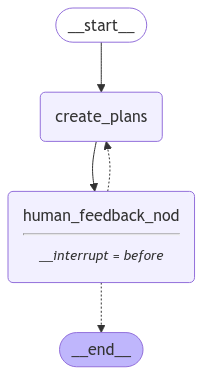

In [14]:
def human_feedback_nod(state: Generate__main_muscle):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: Generate__main_muscle):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_feedback', None)
    if human_analyst_feedback:
        return "create_plans"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(Generate__main_muscle)
builder.add_node("create_plans", create_plans)
builder.add_node("human_feedback_nod", human_feedback_nod)
builder.add_edge(START, "create_plans")
builder.add_edge("create_plans", "human_feedback_nod")
builder.add_conditional_edges("human_feedback_nod", should_continue, ["create_plans", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback_nod'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [15]:
# Input
max_sub_muscles = 1
goal = "lose weight"
intensity= "high"
tall=178
weight=60
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"goal":goal,"max_sub_muscles":max_sub_muscles,"instensity":intensity,"tall":tall,"weight":weight}, thread, stream_mode="values"):
    # Review
    muscle_workouts = event.get('muscle_workouts', '')
    if muscle_workouts:
        for set in muscle_workouts:
            print(set)

i am here at create_plans
('muscle_workouts', [{'main_muscle': 'Chest', 'sub_muscle': ['Pectoralis major'], 'level_of_cardio': 'moderate'}, {'main_muscle': 'Back', 'sub_muscle': ['Trapezius'], 'level_of_cardio': 'moderate'}, {'main_muscle': 'Shoulders', 'sub_muscle': ['Deltoids'], 'level_of_cardio': 'moderate'}, {'main_muscle': 'Biceps', 'sub_muscle': ['Biceps brachii'], 'level_of_cardio': 'low'}, {'main_muscle': 'Triceps', 'sub_muscle': ['Triceps brachii'], 'level_of_cardio': 'low'}, {'main_muscle': 'Legs', 'sub_muscle': ['Quadriceps'], 'level_of_cardio': 'high'}, {'main_muscle': 'Core', 'sub_muscle': ['Abdominals'], 'level_of_cardio': 'low'}])


In [16]:
state = graph.get_state(thread)
print(state)

StateSnapshot(values={'goal': 'lose weight', 'max_sub_muscles': 1, 'tall': 178, 'weight': 60, 'muscle_workouts': Perspectives(muscle_workouts=[{'main_muscle': 'Chest', 'sub_muscle': ['Pectoralis major'], 'level_of_cardio': 'moderate'}, {'main_muscle': 'Back', 'sub_muscle': ['Trapezius'], 'level_of_cardio': 'moderate'}, {'main_muscle': 'Shoulders', 'sub_muscle': ['Deltoids'], 'level_of_cardio': 'moderate'}, {'main_muscle': 'Biceps', 'sub_muscle': ['Biceps brachii'], 'level_of_cardio': 'low'}, {'main_muscle': 'Triceps', 'sub_muscle': ['Triceps brachii'], 'level_of_cardio': 'low'}, {'main_muscle': 'Legs', 'sub_muscle': ['Quadriceps'], 'level_of_cardio': 'high'}, {'main_muscle': 'Core', 'sub_muscle': ['Abdominals'], 'level_of_cardio': 'low'}])}, next=('human_feedback_nod',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efbaef9-eaf5-6df5-8001-96117e9f526d'}}, metadata={'source': 'loop', 'writes': {'create_plans': {'muscle_workouts': Perspectives(muscle_

In [17]:
def search_exercises(state):
    """Search for exercises for the sub-muscle groups."""
    # Extract muscle workouts list from state or default to an empty list
    muscle_workouts = state.get("muscle_workouts", [])
    muscle_workouts=muscle_workouts.muscle_workouts
    exercises = []
    print("Starting exercise search...")
    #print(muscle_workouts.muscle_workouts[0]["sub_muscle"][0])

    # Iterate through the list of muscle workout dictionaries
    for muscle in muscle_workouts: 
        main_muscle = muscle["main_muscle"] # Fetch main muscle
        sub_muscle_list = muscle.get("sub_muscle", [])  # Fetch list of sub-muscles
        
        print(f"Main Muscle: {main_muscle}, Sub-Muscles: {sub_muscle_list}")
        
        # Iterate over the sub-muscles and fetch exercises
        for sub_muscle in sub_muscle_list:
            print(f"Fetching exercises for Main Muscle: {main_muscle}, Sub-Muscle: {sub_muscle}")
            
            # Use the tool to fetch exercises
            results = search_exercises_sqlite(main_muscle,  sub_muscle)
            
            if results:
                exercises.append({
                    "main_muscle": main_muscle,
                    "sub_muscle": sub_muscle,
                    "exercises": results
                })
            else:
                print(f"No exercises found for Sub-Muscle: {sub_muscle}")

    print("Exercise search complete.")
    return {"exercises": exercises}


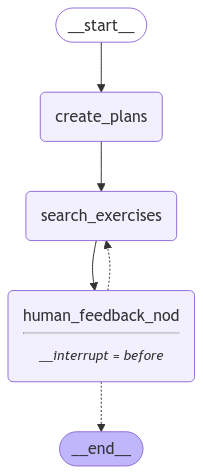

In [18]:

# Add a new graph
builder2 = StateGraph(Generate__main_muscle)

# Nodes
builder2.add_node("create_plans", create_plans)
builder2.add_node("search_exercises", search_exercises)
builder2.add_node("human_feedback_nod", human_feedback_nod)

# Edges
builder2.add_edge(START, "create_plans")
builder2.add_edge("create_plans", "search_exercises")
builder2.add_edge("search_exercises", "human_feedback_nod")
builder2.add_conditional_edges("human_feedback_nod", should_continue, ["search_exercises", END])

# Compile and visualize
graph2 = builder2.compile(interrupt_before=['human_feedback_nod'], checkpointer=memory)
display(Image(graph2.get_graph(xray=1).draw_mermaid_png()))


In [19]:
# Input
max_sub_muscles = 1
goal = "lose weight"
intensity= "high"
tall=178
weight=60
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph2.stream({"goal":goal,"max_sub_muscles":max_sub_muscles,"instensity":intensity,"tall":tall,"weight":weight}, thread, stream_mode="values"):
    # Review
    exercises = event.get('exercises', '')
    if exercises:
        for set in exercises:
            print(set)

i am here at create_plans
Starting exercise search...
Main Muscle: Chest, Sub-Muscles: ['Pectoralis major']
Fetching exercises for Main Muscle: Chest, Sub-Muscle: Pectoralis major
I am here
Main Muscle: Back, Sub-Muscles: ['Trapezius']
Fetching exercises for Main Muscle: Back, Sub-Muscle: Trapezius
I am here
Main Muscle: Shoulders, Sub-Muscles: ['Deltoids']
Fetching exercises for Main Muscle: Shoulders, Sub-Muscle: Deltoids
I am here
No exercises found for Sub-Muscle: Deltoids
Main Muscle: Biceps, Sub-Muscles: ['Biceps brachii']
Fetching exercises for Main Muscle: Biceps, Sub-Muscle: Biceps brachii
I am here
Main Muscle: Triceps, Sub-Muscles: ['Triceps brachii']
Fetching exercises for Main Muscle: Triceps, Sub-Muscle: Triceps brachii
I am here
No exercises found for Sub-Muscle: Triceps brachii
Main Muscle: Legs, Sub-Muscles: ['Quadriceps']
Fetching exercises for Main Muscle: Legs, Sub-Muscle: Quadriceps
I am here
No exercises found for Sub-Muscle: Quadriceps
Main Muscle: Core, Sub-Musc

In [20]:
state = graph2.get_state(thread)
print(state)

StateSnapshot(values={'goal': 'lose weight', 'max_sub_muscles': 1, 'tall': 178, 'weight': 60, 'muscle_workouts': Perspectives(muscle_workouts=[{'main_muscle': 'Chest', 'sub_muscle': ['Pectoralis major'], 'level_of_cardio': 'moderate'}, {'main_muscle': 'Back', 'sub_muscle': ['Trapezius'], 'level_of_cardio': 'moderate'}, {'main_muscle': 'Shoulders', 'sub_muscle': ['Deltoids'], 'level_of_cardio': 'moderate'}, {'main_muscle': 'Biceps', 'sub_muscle': ['Biceps brachii'], 'level_of_cardio': 'low'}, {'main_muscle': 'Triceps', 'sub_muscle': ['Triceps brachii'], 'level_of_cardio': 'low'}, {'main_muscle': 'Legs', 'sub_muscle': ['Quadriceps'], 'level_of_cardio': 'high'}, {'main_muscle': 'Core', 'sub_muscle': ['Abdominals'], 'level_of_cardio': 'low'}]), 'exercises': [{'main_muscle': 'Chest', 'sub_muscle': 'Pectoralis major', 'exercises': [[18, 'Flat Barbell Bench Press', '4 sets', '8-12 reps', 'Middle chest (pectoralis major)', 'Builds overall chest size and strength.', 'Chest'], [19, 'Incline Barb

: 